**<h1><center><center><center>BÀI TẬP COLAB SỐ 01</center></h1>**
**<h1><center><center><center>RECOGNIZING HAND-WRITTEN DIGITS</center></h1>**
###LỚP: CS114.021
###NHÓM:
1. Đặng Thanh Ngân - *22520929*
2. Phạm Thanh Thảo - *22521373*



# MÔ TẢ BÀI TOÁN

- Input: Chữ số viết tay
- Output: Kết quả nhận dạng

Tham khảo: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

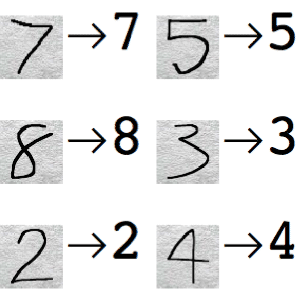

# MNIST Handwritten Digit Classification Dataset

- Các ảnh greyscale có kích thước 28x28
- Bộ Training Data gồm 60000 bức ảnh

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


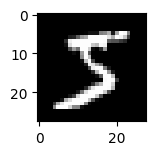

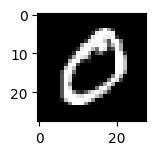

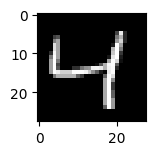

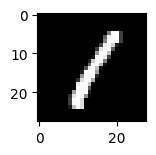

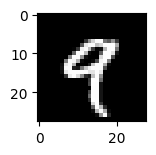

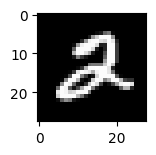

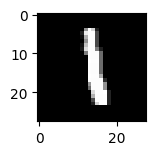

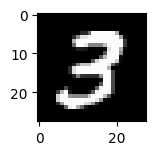

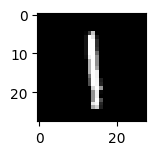

In [ ]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
  # show the figure
  plt.show()

In [43]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from numpy import argmax
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.models import load_model

## Load Dataset

- we know that the images are all pre-aligned (e.g. each image only contains a hand-drawn digit), that the images all have the same square size of 28×28 pixels, and that the images are grayscale. Therefore, we can load the images and reshape the data arrays to have a single color channel.
- a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes

In [ ]:
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()

  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))

  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

## Prepare Pixel Data

- We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

- We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

- A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [ ]:
def prep_pixels(train, test):
  # convert from integers to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')

  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0

  # return normalized images
  return train_norm, test_norm

## Define Model
### Định nghĩa Model
*   Áp dụng mạng Neural: gồm 5 lớp
*   Model sử dụng thuật toán phân loại crossentropy




In [ ]:
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

## Evaluate Model

In [ ]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
  scores, histories = list(), list()

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)

  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):

    # define model
    model = define_model()

    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)

    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))

    # stores scores
    scores.append(acc)
    histories.append(history)

  return scores, histories

## Present Results

In [ ]:
def summarize_diagnostics(histories):
  for i in range(len(histories)):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')

    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [ ]:
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))

  # box and whisker plots of results
  plt.boxplot(scores)
  plt.show()

In [ ]:
def run_test_harness():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)

  # evaluate model
  scores, histories = evaluate_model(trainX, trainY)

  # learning curves
  summarize_diagnostics(histories)

  # summarize estimated performance
  summarize_performance(scores)

In [ ]:
# entry point, run the test harness
run_test_harness()

Khi huấn luyện trên bộ dữ liệu mnist, model có độ chính xác đến **98.755%**

## Save Final Model


*   Hàm huấn luyện Model sử dụng trainX để train
*   Sau khi huốn luyện xong Model được lưu lại dưới dạng file 'final_model.h5'



In [ ]:
# run the test harness for evaluating a model
def run_test_harness2():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # define model
  model = define_model()

  # fit model
  model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)

  # save model
  model.save('final_model.h5')

## Evaluate Final Model

In [ ]:
run_test_harness2()

## Make Prediction


*   Tải hình ảnh từ file, chuyển ảnh sang trắng đen dùng grayscale=True, và kích thước của ảnh là 28x28 pixel
*   List item



In [ ]:
def load_image(filename):
  # load the image
  img = load_img(filename, grayscale=True, target_size=(28, 28))

  # convert to array
  img = img_to_array(img)

  # reshape into a single sample with 1 channel
  img = img.reshape(1, 28, 28, 1)

  # prepare pixel data
  img = img.astype('float32')
  img = img / 255.0

  return img

In [2]:
# load an image and predict the class
def run_example(filename):
  # load the image
  #for i in range(4):
  img = load_img_new(filename)

  # load model
  model = load_model('/content/final_model.h5')

  # predict the class
  predict_value = model.predict(img)

  digit = argmax(predict_value)
  print(f'predict: {digit}\n')
  return digit



**<a name ="xulyhinhanh"></a>
## **Tiền xử lý hình ảnh**

1. Vì hình ảnh trong bộ dữ liệu digits datastes là hình trắng đen (nền đen, chữ trắng) nên bước đầu chúng em chuyển hình ảnh sang màu trắng đen.
2. Làm mờ ảnh
3. Tìm nét các nét của chữ số
4. Làm giãn ảnh và xói mòn ảnh
5. Điều chỉnh ảnh phù hợp với điều kiện đầu vào của Model


**Hàm tiền xử lý hình ảnh:**

In [44]:
from PIL import Image
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import glob

In [92]:
def load_img_new(path, size=(28,28)):


  # Đọc hình ảnh, chuyển sang hình ảnh đen trắng
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

  # Làm mờ ảnh, và nhiễu ảnh sử dụng hàm GaussianBlur, với độ (7,7)
  blurred_image = cv2.GaussianBlur(img, (7, 7), 0)

  #plt.imshow(blurred_image, cmap="gray")
  #plt.show()

  # Phát hiện cạnh bằng thuật toán Canny
  edges = cv2.Canny(blurred_image, threshold1=50, threshold2=150)
  #plt.imshow(edges)
  #plt.show()

  # Làm giãn hình ảnh, giúp các nét khi Canny lớn hơn để model có thể dự đoán được
  # kernel hạt nhân có độ giãn nở là 10,10 giúp cho các nét to hơn
  # Việc giãn hình ảnh được lặp lại 4 lần giúp cho các nét chữ được loan truyền rộng hơn
  kernel = np.ones((10,10), np.uint8)
  img_dilation = cv2.dilate(edges, kernel, iterations=4)

  # Sau đó làm xói mòn ảnh giúp loại bỏ những nét gây nhiễu
  kernel = np.ones((4,4), np.uint8)
  img_erode = cv2.erode(img_dilation,kernel)

  # Thay đổi kích thước hình ảnh thành 28x28 pixel để phù hợp với ảnh đầu vào của model
  img_resized = cv2.resize(img_erode, (28, 28))

  # Chuyển đổi hình ảnh
  img_bw = img_resized / 255.0

  # Định hình lại hình ảnh cho đầu vào mô hình

  img_array = np.array(img_bw).astype(np.float32)
  #Bước này định hình lại mảng để có bốn chiều.CNN trong các thư viện như Keras mong đợi dữ liệu ở định dạng(samples, height, width, channels)
  #Kích thước cuối cùng là 1, cho biết chỉ có một kênh màu (thang độ xám). Nếu là ảnh màu ở chế độ RGB thì con số này sẽ là 3.
  img_resized = img_array.reshape(1, 28, 28, 1)

  # Hiển thị hình ảnh
  plt.imshow(img_resized.squeeze())
  plt.figure(figsize=(2, 2))
  plt.show()
  return img_resized

# Lấy data từ github

In [19]:
!git clone https://github.com/thepistachilicious/CS114.O21.git

fatal: destination path 'CS114.O21' already exists and is not an empty directory.


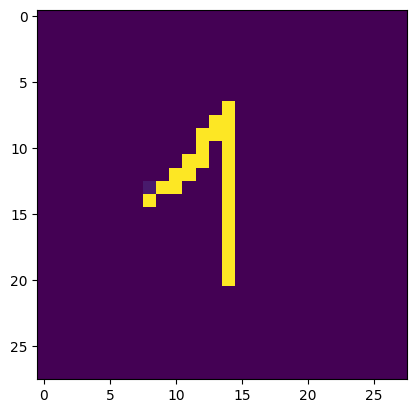

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 82ms/step
predict: 1

1


In [93]:
print(run_example('/content/CS114.O21/LAB01/data/22520929/1/1_3.jpg'))

Việc xử lý ảnh thông qua làm mờ, canny và dilate cho thấy hình ảnh sát với hình ảnh thực tế.

Model đoán đúng hình ảnh ví dụ.

=> Để có thể đánh giá được model thì chúng em cho model đi qua mô hình 60 ảnh viết tay của nhóm

### PREDICT HÌNH ẢNH SAU KHI ĐÃ XỬ LÝ

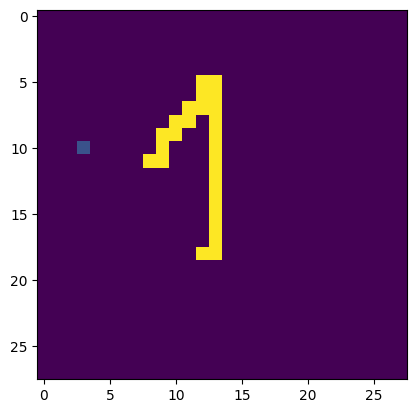

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 162ms/step
predict: 9



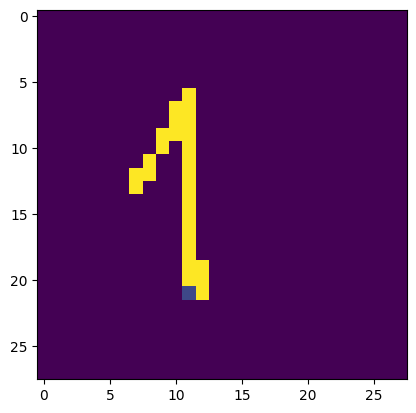

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 111ms/step
predict: 7



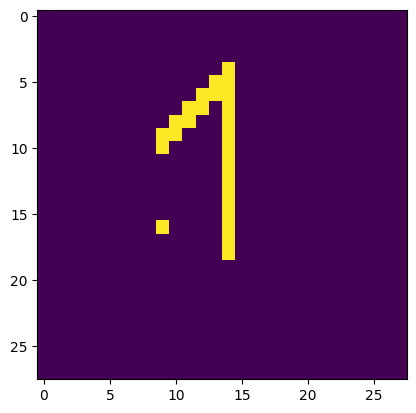

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 80ms/step
predict: 1



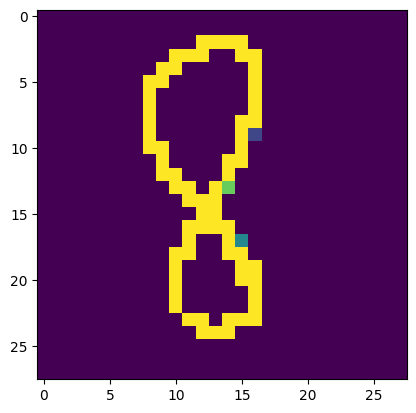

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 73ms/step
predict: 8



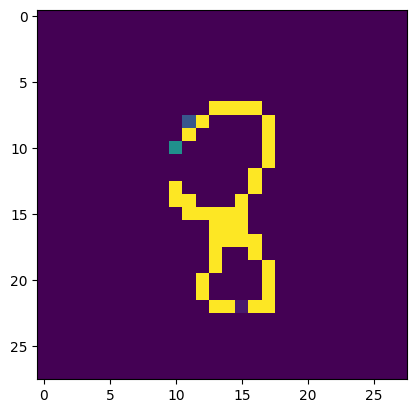

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 75ms/step
predict: 8



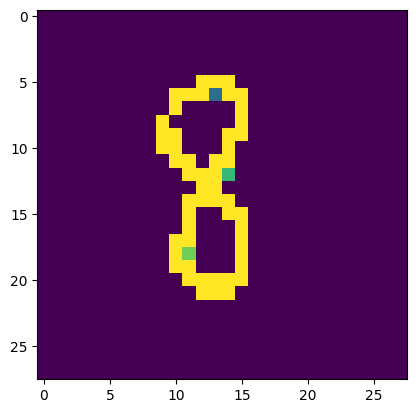

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 72ms/step
predict: 8



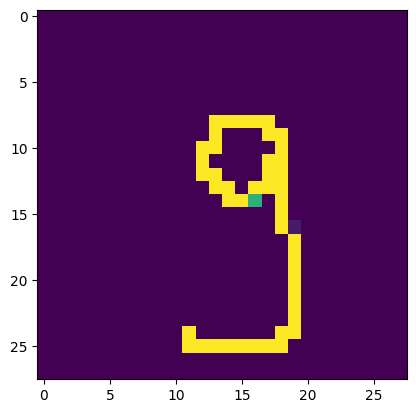

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 66ms/step
predict: 3



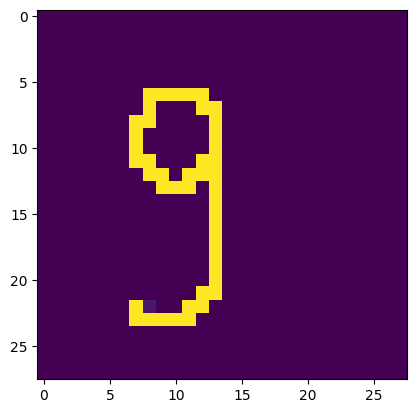

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 81ms/step
predict: 5



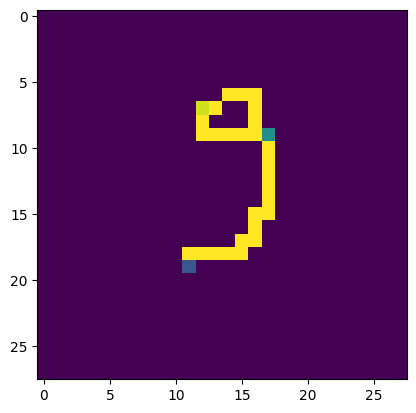

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 71ms/step
predict: 9



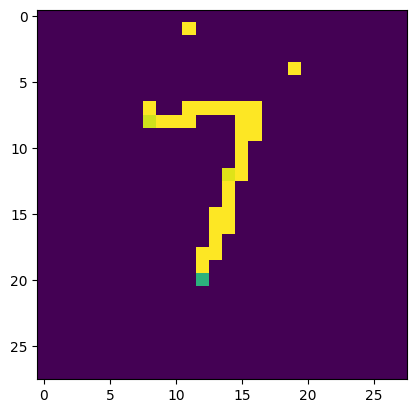

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 70ms/step
predict: 7



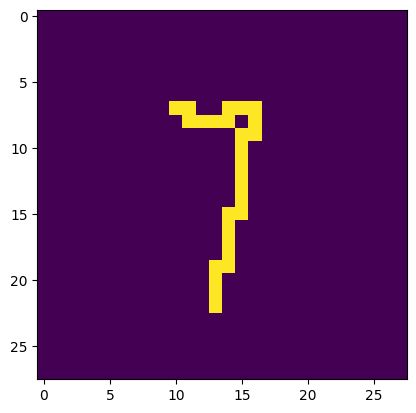

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 66ms/step
predict: 7



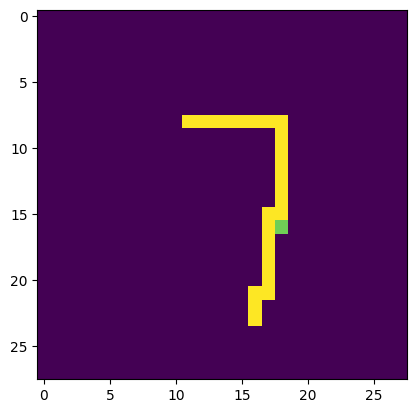

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 71ms/step
predict: 7



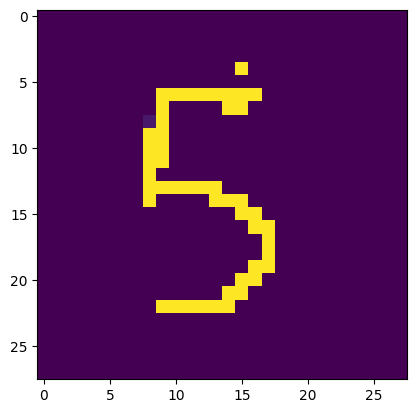

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 68ms/step
predict: 5



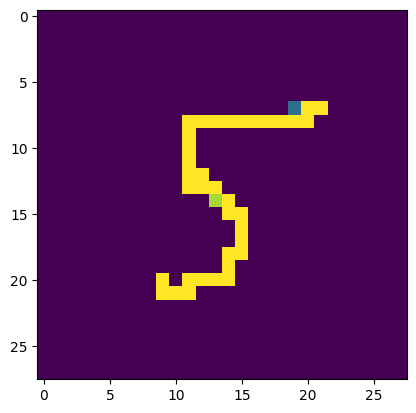

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 76ms/step
predict: 5



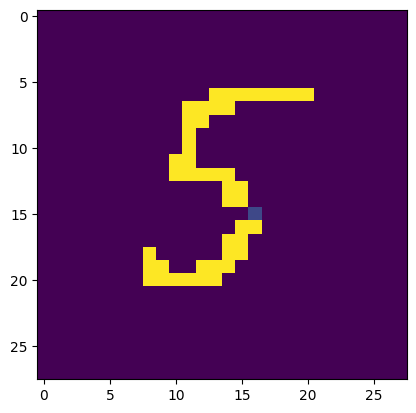

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 71ms/step
predict: 5



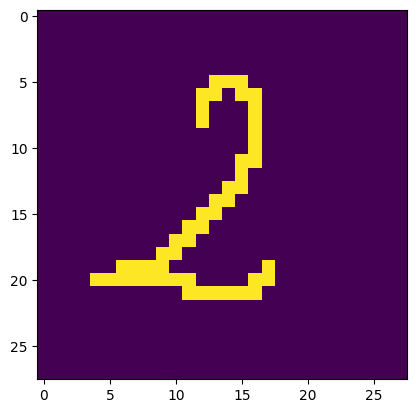

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 72ms/step
predict: 2



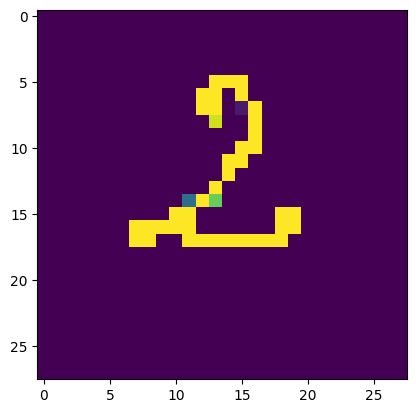

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 69ms/step
predict: 2



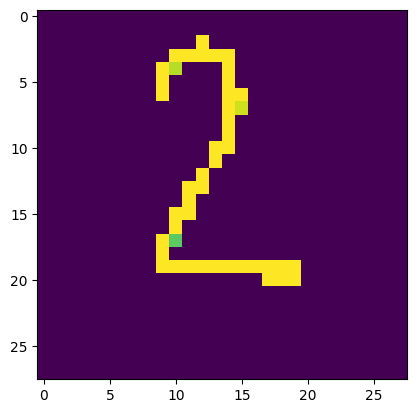

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 139ms/step
predict: 2



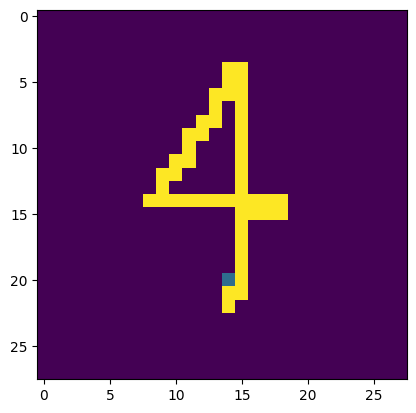

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 440ms/step
predict: 4



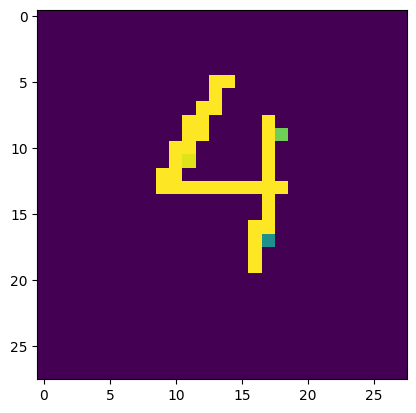

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 157ms/step
predict: 4



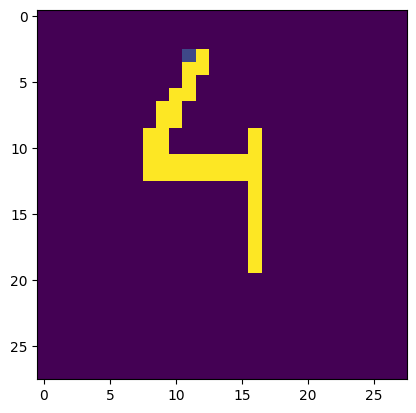

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 184ms/step
predict: 9



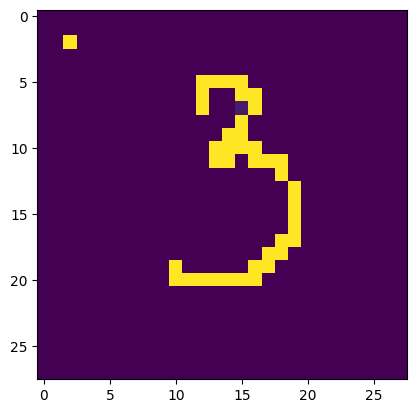

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 133ms/step
predict: 3



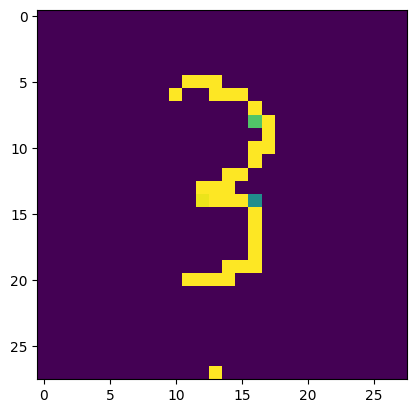

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 123ms/step
predict: 3



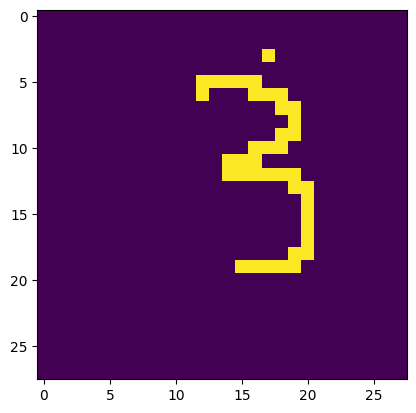

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 124ms/step
predict: 3



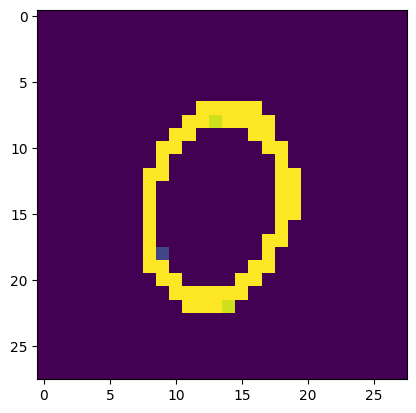

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 103ms/step
predict: 0



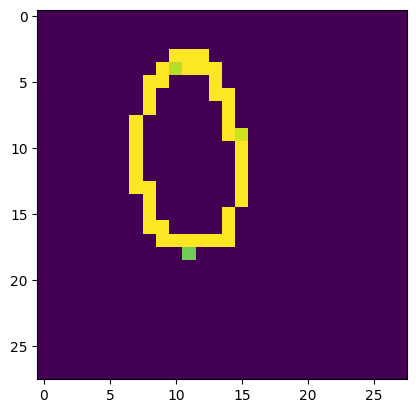

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 121ms/step
predict: 9



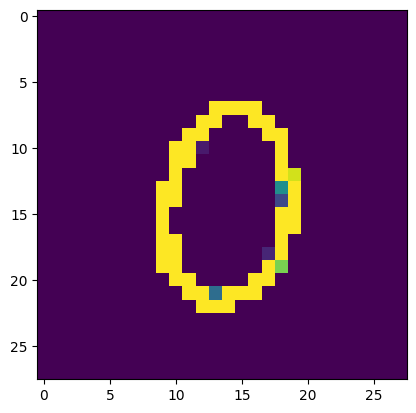

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 154ms/step
predict: 0



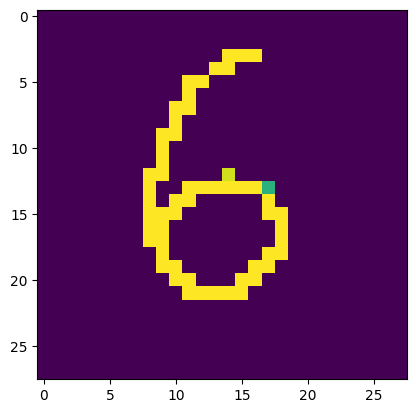

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 160ms/step
predict: 6



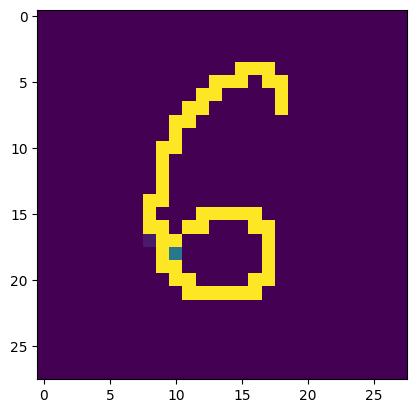

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 200ms/step
predict: 6



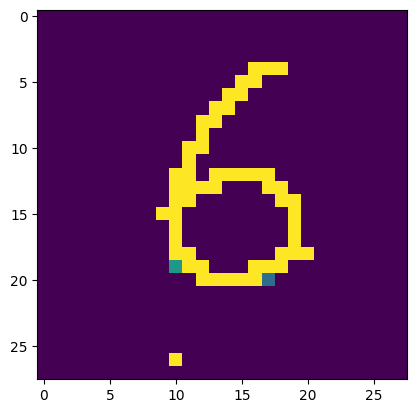

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 248ms/step
predict: 6



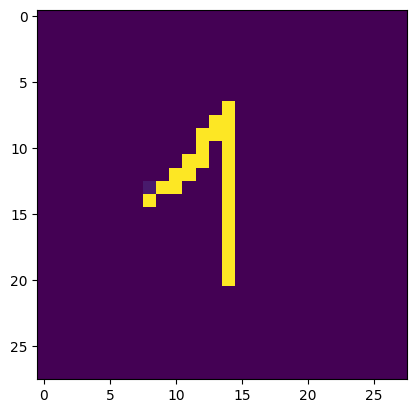

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 385ms/step
predict: 1



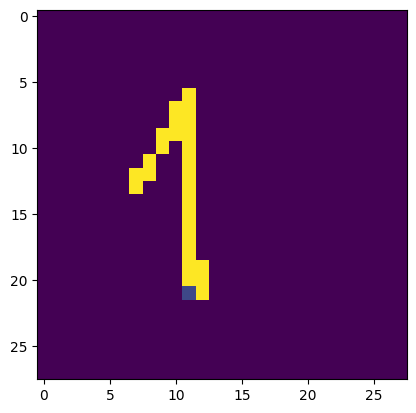

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 220ms/step
predict: 7



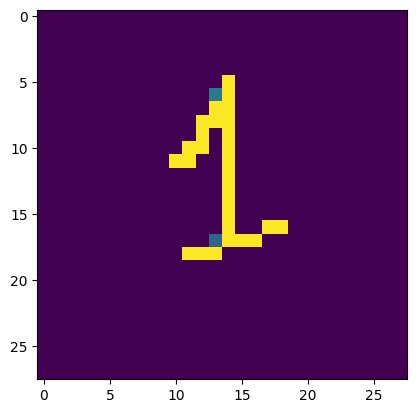

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 141ms/step
predict: 1



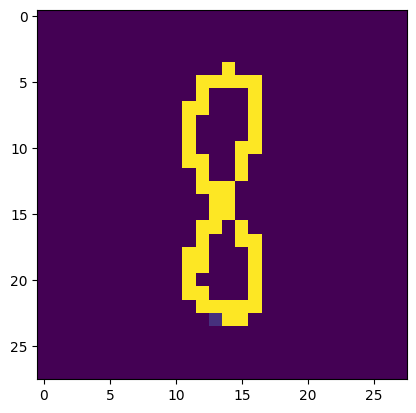

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 124ms/step
predict: 8



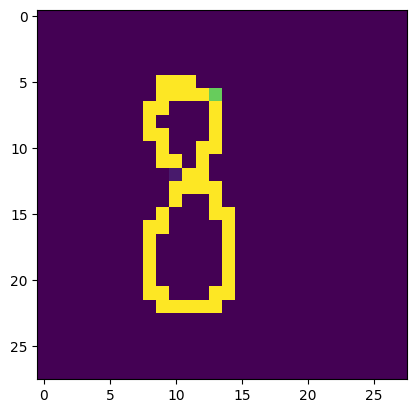

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 127ms/step
predict: 8



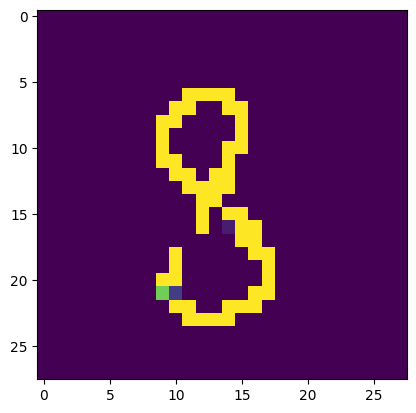

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 72ms/step
predict: 8



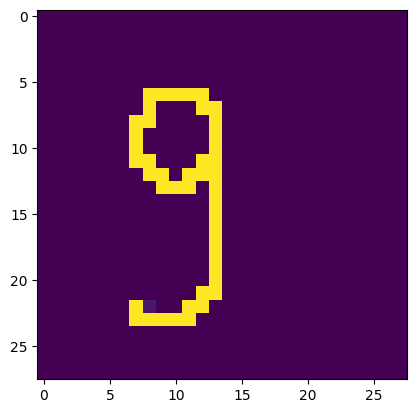

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 72ms/step
predict: 5



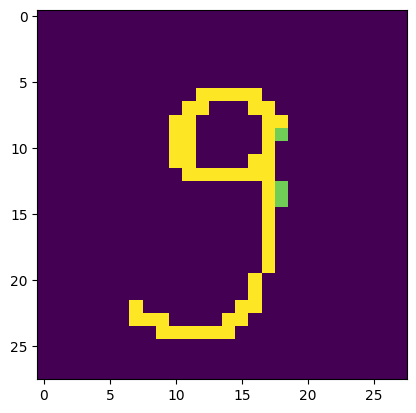

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 73ms/step
predict: 3



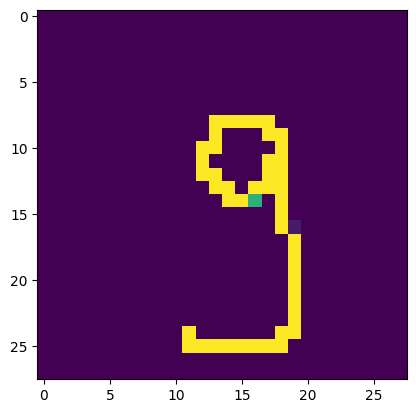

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 85ms/step
predict: 3



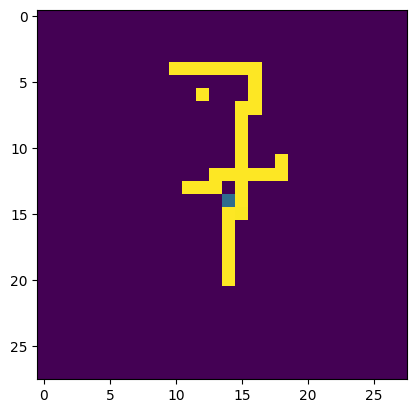

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 75ms/step
predict: 3



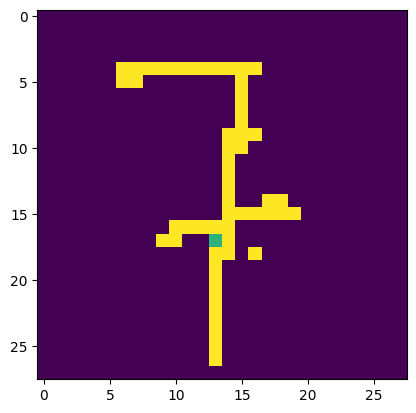

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 70ms/step
predict: 7



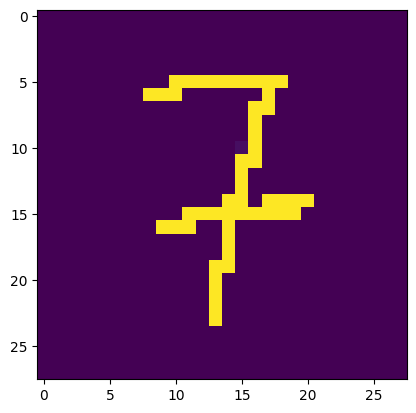

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 70ms/step
predict: 7



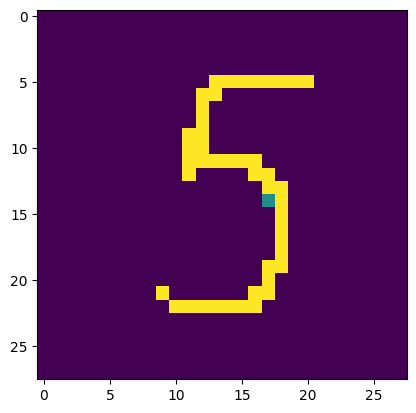

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 73ms/step
predict: 5



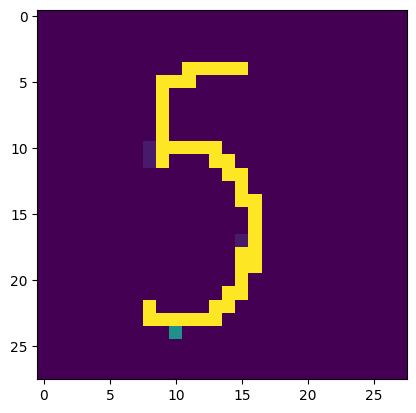

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 69ms/step
predict: 5



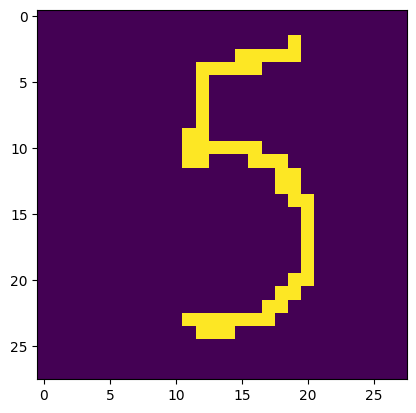

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 71ms/step
predict: 5



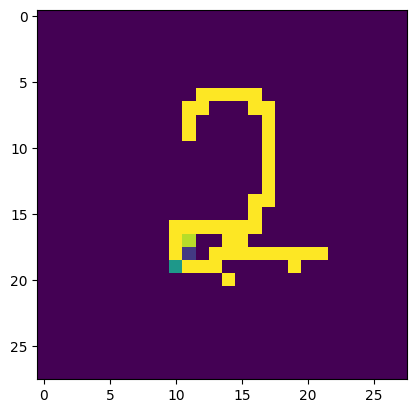

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 69ms/step
predict: 2



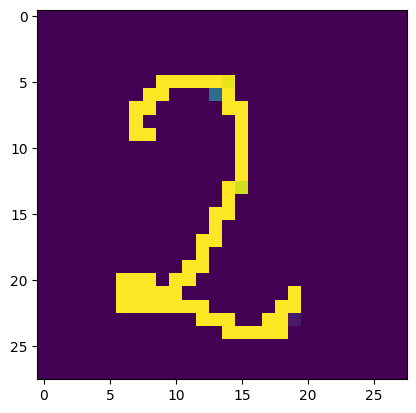

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 75ms/step
predict: 2



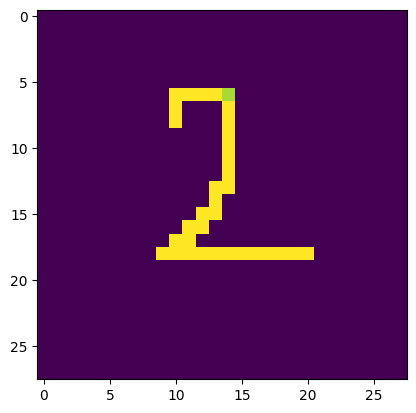

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 116ms/step
predict: 2



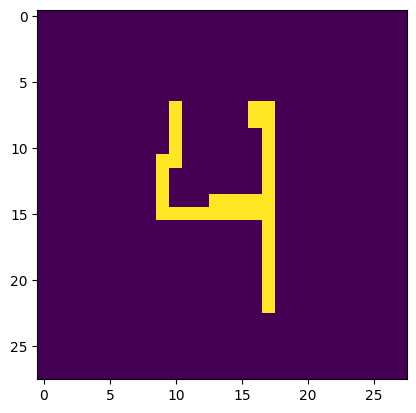

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 110ms/step
predict: 4



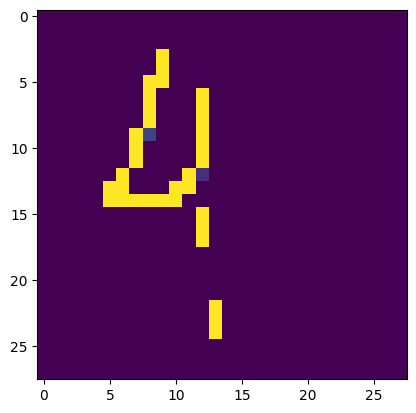

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 101ms/step
predict: 4



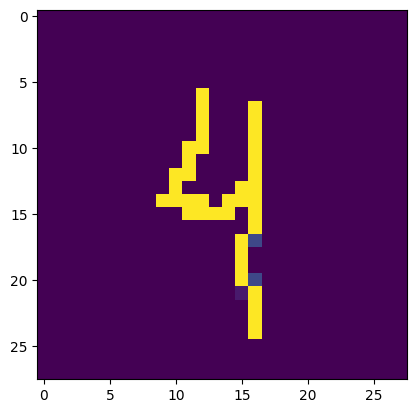

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 109ms/step
predict: 4



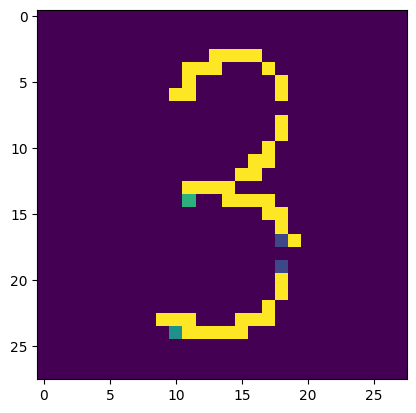

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 73ms/step
predict: 3



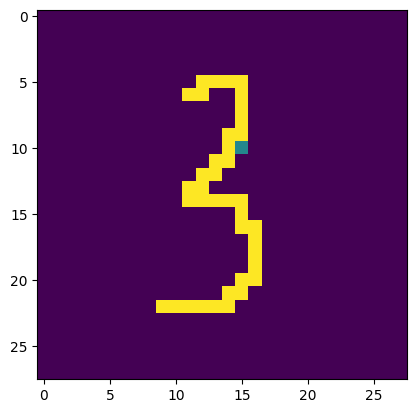

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 68ms/step
predict: 3



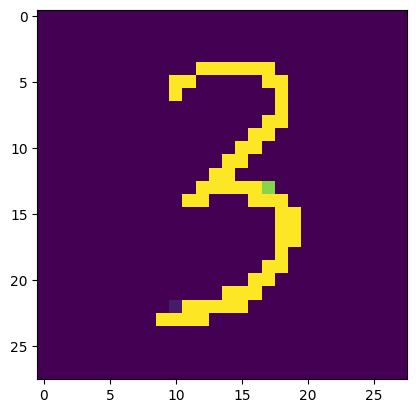

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 69ms/step
predict: 3



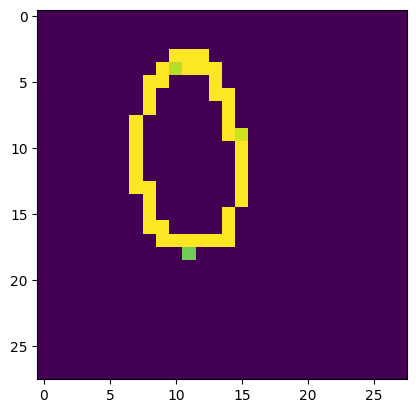

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 67ms/step
predict: 9



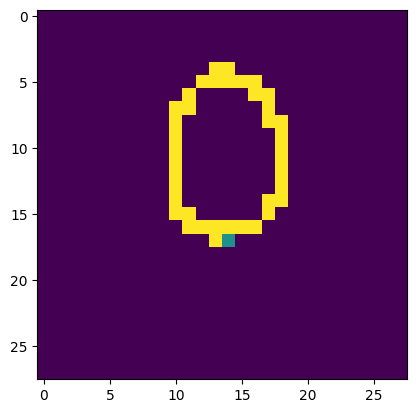

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 67ms/step
predict: 9



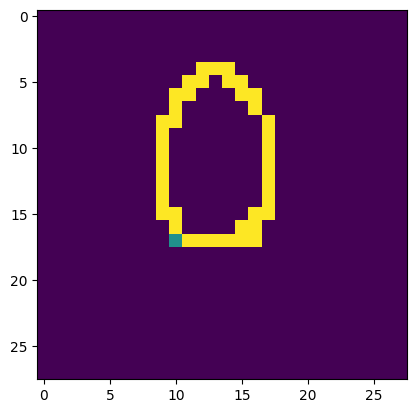

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 67ms/step
predict: 9



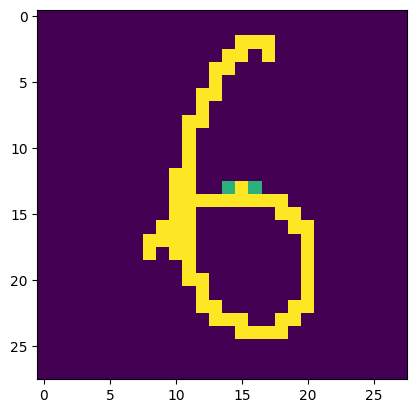

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 70ms/step
predict: 6



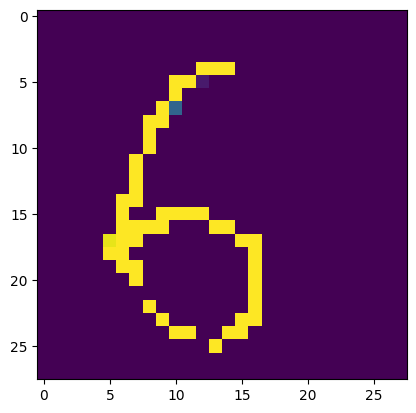

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 68ms/step
predict: 5



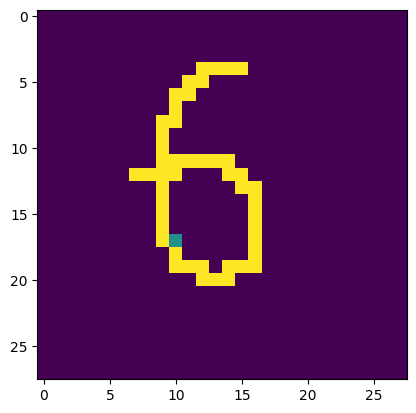

<Figure size 200x200 with 0 Axes>

1/1 [==============================] - 0s 68ms/step
predict: 5

Dung 44 anh, sai 16 anh


In [98]:
correct = 0
wrong = 0
number= [[0 for _ in range(10)] for _ in range(10)]
directory = '/content/CS114.O21/LAB01/data'
for mssv_folder in os.listdir(directory):
  mssv_folder_path = os.path.join(directory, mssv_folder)
  for digit_folder in os.listdir(mssv_folder_path):
    digit_folder_path = os.path.join(mssv_folder_path, digit_folder)
    for filename in glob.glob(digit_folder_path + '/*.jpg'):
      predict_digit = run_example(filename)
      if predict_digit==int(digit_folder_path[-1]):
        correct += 1
      else:
        wrong += 1
      number[int(digit_folder_path[-1])][predict_digit]+=1
print(f'Dung {correct} anh, sai {wrong} anh')

In [ ]:
print(f"Accuracy: {correct*100/60}")

In [102]:
for i, row in enumerate(number):
    print(f"{i}", end="__  ")
    for j, val in enumerate(row):
        print(f"({j}): {val}", end=", ")
    print()

0__  (0): 2, (1): 0, (2): 0, (3): 0, (4): 0, (5): 0, (6): 0, (7): 0, (8): 0, (9): 4, 
1__  (0): 0, (1): 3, (2): 0, (3): 0, (4): 0, (5): 0, (6): 0, (7): 2, (8): 0, (9): 1, 
2__  (0): 0, (1): 0, (2): 6, (3): 0, (4): 0, (5): 0, (6): 0, (7): 0, (8): 0, (9): 0, 
3__  (0): 0, (1): 0, (2): 0, (3): 6, (4): 0, (5): 0, (6): 0, (7): 0, (8): 0, (9): 0, 
4__  (0): 0, (1): 0, (2): 0, (3): 0, (4): 5, (5): 0, (6): 0, (7): 0, (8): 0, (9): 1, 
5__  (0): 0, (1): 0, (2): 0, (3): 0, (4): 0, (5): 6, (6): 0, (7): 0, (8): 0, (9): 0, 
6__  (0): 0, (1): 0, (2): 0, (3): 0, (4): 0, (5): 2, (6): 4, (7): 0, (8): 0, (9): 0, 
7__  (0): 0, (1): 0, (2): 0, (3): 1, (4): 0, (5): 0, (6): 0, (7): 5, (8): 0, (9): 0, 
8__  (0): 0, (1): 0, (2): 0, (3): 0, (4): 0, (5): 0, (6): 0, (7): 0, (8): 6, (9): 0, 
9__  (0): 0, (1): 0, (2): 0, (3): 3, (4): 0, (5): 2, (6): 0, (7): 0, (8): 0, (9): 1, 




*   Số 0 đoán đúng được 2 trường hợp, và đoán sai thành sô 9 đến 4 trường hợp
*   Số 1 đoán đúng 3 trường hợp, và đoán sai thành 7 có 2 trường hợp và thành 9 có 1 trường hợp
*   Số 2 đoán đúng được 100%
*   Số 3 đoán đúng được 100%
*   Số 4 đoán trúng được 5 trường hợp, 1 trường hợp còn lại đoán sai thành số 9
*   Số 5 đoán trúng được 100%
*   Số 6 đoán trúng được 4 trường hợp, còn lại đoán sai thành số 5
*   Số 7 đoán đúng được 5 trường hợp, còn lại đoán là 3
*   Số 8 đoán đúng 100%
*   Số 9 đoán đúng được 1 trường hợp, còn lại có 3 trường hợp đoán sai là 2 và sai 2 trường hợp là số 5

**Số 2,3,5,8 đoán đúng cao**

**Số 9 đoán đúng thấp và dễ đoán sai với những số khác**



# Tổng kết bài tập:
1. Kết quả chạy chữ viết tay thực tế và bộ dữ liệu khác nhau?

  Trong bộ dữ liệu mnist đoán đúng gần 98% dùng phương pháp kiểm tra K-Fold. Khi viết chữ viết tay đưa vào xử lý chỉ đúng khoảng 75%.




3. Những điều làm model không tốt với dữ liệu test?

  Ảnh phải qua nhiều bước xử lý. Xem chi tiết ở phần [Tiền xử lý hình ảnh](#xulyhinhanh)

  + Khi xử lý về hình vuông sẽ làm méo ảnh
  + Quá trình resize khiến ảnh bị mất dữ liệu
  + Việc xử lý màu, nhiễu,.. ảnh hưởng rất nhiều tới kết thông tin của hình ảnh. Ví dụ ở hình

  Ảnh được chụp bị tác động bởi nhiều yếu tố xung quanh:
  + Độ đậm nhạt của nét chữ, màu chữ (bước cắt hình của chúng em chỉ phân biệt tốt giữa pixels đen và trắng và bộ dữ liệu là màu chữ đen nên hình màu chữ khác kết quả nhận diện sẽ không đúng).
  + Nền chữ bị nhiễu (kẻ ô vuông, có gạch ngang,...) cũng làm giảm thiểu độ chính xác của model
  + Độ sáng của môi trường, chất lượng hình ảnh (hình chụp bị dính bóng thiết bị chụp, gặp đồ vật mà khi xử lý bị nhầm lẫn sang pixels đen dẫn đến cắt hình không chính xác,...)
  + Góc chụp của điện thoại (nghiêng, không chính diện mặt chữ,...)





